# 1.Numpy进阶

如果有问题请在群里讨论，题意问题请@姜腾

ddl周六（3.26）23:59，提交前请自己重启kernel运行一遍，只提交ipynb文件，不要把数据和照片打包，代码也不要把图片保存（不要imsave,只要imshow）

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### 1.1 Cauchy Matrix（1.5分）

Cauchy矩阵是一种在多个领域（控制论，插值，矩阵论）都有广泛应用的矩阵，具体定义如下引用自[Wikipedia](https://en.wikipedia.org/wiki/Cauchy_matrix#:~:text=In%20mathematics%2C%20a%20Cauchy%20matrix%2C%20named%20after%20Augustin,n%20matrix%20with%20elements%20aij%20in%20the%20form)：

In mathematics, a Cauchy matrix, named after Augustin Louis Cauchy, is an $m \times n$ matrix with elements $a_{i j}$ in the form
$$
a_{i j}=\frac{1}{x_{i}-y_{j}} ; \quad x_{i}-y_{j} \neq 0, \quad 1 \leq i \leq m, \quad 1 \leq j \leq n
$$
where $x_{i}$ and $y_{j}$ are elements of a field $\mathcal{F}$, and $\left(x_{i}\right)$ and $\left(y_{j}\right)$ are injective sequences (they contain distinct elements).

特别的，大家喜闻乐见的希尔伯特矩阵就是在$x_{i}-y_{j}=i+j-1$条件下的一种特殊Cauchy矩阵。

本题要求用两种方法：Ufunc和nditer两种方式实现示例的Cauchy矩阵计算，并将输出打印。

In [3]:
A = np.arange(5).reshape(5,1) + 4
B = np.arange(3).reshape(1,3)

In [4]:
# 使用ufunc，TODO
# print(A)
# print(B)
C = np.subtract(A, B)
D = 1/C
# print(C)
print(D)
print(1/(A-B))

[[0.25       0.33333333 0.5       ]
 [0.2        0.25       0.33333333]
 [0.16666667 0.2        0.25      ]
 [0.14285714 0.16666667 0.2       ]
 [0.125      0.14285714 0.16666667]]
[[0.25       0.33333333 0.5       ]
 [0.2        0.25       0.33333333]
 [0.16666667 0.2        0.25      ]
 [0.14285714 0.16666667 0.2       ]
 [0.125      0.14285714 0.16666667]]


In [4]:
# 使用nditer，TODO
c = []

for i in np.nditer(A):
	for j in np.nditer(B):
		c.append(1/(i-j))
print(np.array(c).reshape((A.shape[0], B.shape[1])))

[[0.25       0.33333333 0.5       ]
 [0.2        0.25       0.33333333]
 [0.16666667 0.2        0.25      ]
 [0.14285714 0.16666667 0.2       ]
 [0.125      0.14285714 0.16666667]]


### 1.2 Element-wise计算的性能分析（1.5分）

以下是一些将一个矩阵每个元素平方的函数实现。结合课上内容，查阅资料，总结出5条以上有意义的发现。


如：
1. 用户自定义的ufunc性能不如numpy自带的ufunc，是因为numpy自带函数底层用C实现。

In [5]:
import timeit
from numba import jit
import numpy as np

data = np.random.randint(10, size=(500, 300))

def pow_build_in(d):
    return data*data

def pow_ufunc(d):
    return np.square(d)

def pow_my_ufunc(d):
    return np.frompyfunc(lambda x:x*x,1,1)(d)  # 1， 1：参数个数加返回值个数

def pow_loop(d): 
    res = np.zeros_like(d) 
    for i in range(500): 
        for j in range(300): 
            res[i,j]=d[i,j] ** 2 
    return res

@jit
def pow_loop_jit(d): 
    res = np.zeros_like(d) 
    for i in range(500): 
        for j in range(300): 
            res[i,j]=d[i,j] ** 2 
    return res

def pow_loop_per_row(d): 
    res = np.zeros_like(d) 
    for i in range(500): 
        res[i,:] = d[i,:] ** 2 
    return res

@jit
def pow_loop_per_row_jit(d): 
    res = np.zeros_like(d) 
    for i in range(500): 
        res[i,:] = d[i,:] ** 2 
    return res

def pow_nditer_default(d):
    res = np.zeros_like(d) 
    it = np.nditer([d, res], op_flags=['readwrite']) 
    for i, r in it:
        r[...] = i ** 2 
    return res 

def pow_nditer_multi(d):
    res = np.zeros_like(d) 
    it = np.nditer([d, res], flags =['multi_index'], op_flags=['readwrite']) 
    for i, r in it: 
        r[...] = i ** 2 
    return res 

def pow_nditer_ext_by_C(d): 
    d = np.array(d, order = 'C') 
    res = np.zeros_like(d, order = 'C') 
    it = np.nditer([d, res], flags = ['external_loop'], op_flags=['readwrite'], order='C') 
    for i, r in it: 
        r[...] = i ** 2 
    return res 

def pow_nditer_ext_by_F(d): 
    d = np.array(d, order = 'F') 
    res = np.zeros_like(d, order = 'F') 
    it = np.nditer([d, res], flags = ['external_loop'], op_flags=['readwrite'], order='F') 
    for i, r in it: 
        r[...] = i ** 2 
    return res 

def pow_nditer_ext_bad(d):  
    d = np.array(d, order = 'C') 
    res = np.zeros_like(d, order = 'C') 
    it = np.nditer([d, res], flags = ['external_loop'], op_flags=['readwrite'], order='F') 
    for i, r in it: 
        r[...] = i ** 2 
    return res 


%timeit pow_build_in(data)
%timeit pow_ufunc(data)
%timeit pow_my_ufunc(data)
%timeit pow_loop(data)
%timeit pow_loop_jit(data)
%timeit pow_loop_per_row(data)
%timeit pow_loop_per_row_jit(data)
%timeit pow_nditer_default(data)
%timeit pow_nditer_multi(data)
%timeit pow_nditer_ext_by_C(data)
%timeit pow_nditer_ext_by_F(data)
%timeit pow_nditer_ext_bad(data)

66.4 µs ± 6.27 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
52.2 µs ± 7.45 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
7.42 ms ± 99.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
32.6 ms ± 1.23 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
The slowest run took 6.64 times longer than the fastest. This could mean that an intermediate result is being cached.
294 µs ± 196 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
857 µs ± 101 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
180 µs ± 71.9 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
102 ms ± 945 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
103 ms ± 293 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.22 ms ± 48.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.35 ms ± 36.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
835 µs ± 22.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


输入你的发现：

	2. 单纯用循环又比自定义的Ufunc来的慢
	3. 同样使用循环来做，使用@jit（Just-in-time compilation）即时编译要快很多
	4. 每次使用的ufunc覆盖的数据越多，整体的速度越快（整体使用快于按行操作，快于逐元素操作）
	5. 仅仅使用默认迭代器nditer会非常慢
	6. 迭代器使用external_loop就会快不少

# 2.PCA 与 KMeans


### 2.1 债券yield curve的降维与重建：（4分+1分（最后1分为附加分））

PCA在各个领域的应用十分广泛，比如我们喜闻乐见的金融领域。我们都知道债券这种金融产品有各种期限结构，比如三个月后，一年后或者三十年后到期。

同时我们还知道债券有收益率（[bond yield](https://wiki.mbalib.com/wiki/Bond_yield)）这种属性，但是完成本次作业不用知道它到底是个啥，只需要知道它在金融领域里十分重要。

我们把每一天的数据想象成一个样本（Sample），这一天的各个期限的债券的收益率当成特征（Feature），就构成了我们基本问题。

In [6]:
import pandas as pd
import numpy as np

In [7]:
# 载入数据集，不用操作
maturities=list(range(1,31))

path='./YC-Dataset.csv'

dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d')
yields_df = (pd.read_csv(path,index_col='TIME_PERIOD',parse_dates=['TIME_PERIOD'],date_parser=dateparse)).iloc[:,9:] # 不要月度的

display(yields_df)

/home/gyr/anaconda3/envs/rlgpu/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


,Yield 1Y,Yield 2Y,Yield 3Y,Yield 4Y,Yield 5Y,Yield 6Y,Yield 7Y,Yield 8Y,Yield 9Y,Yield 10Y,...,Yield 21Y,Yield 22Y,Yield 23Y,Yield 24Y,Yield 25Y,Yield 26Y,Yield 27Y,Yield 28Y,Yield 29Y,Yield 30Y
TIME_PERIOD,,,,,,,,,,,,,,,,,,,,,
2004-09-06,2.298838,2.641262,2.951578,3.223235,3.457222,3.657429,3.828505,3.974939,4.100712,4.209220,...,4.808953,4.836016,4.860795,4.883558,4.904536,4.923925,4.941896,4.958596,4.974153,4.988680
2004-09-07,2.328891,2.679766,2.987293,3.252486,3.479518,3.673463,3.839294,3.981472,4.103839,4.209626,...,4.798185,4.824870,4.849308,4.871763,4.892459,4.911590,4.929323,4.945804,4.961158,4.975495
2004-09-08,2.346666,2.706542,3.016998,3.282196,3.507894,3.699959,3.863753,4.003922,4.124390,4.228419,...,4.805488,4.831593,4.855497,4.877459,4.897700,4.916408,4.933749,4.949863,4.964876,4.978894
2004-09-09,2.308988,2.646224,2.945649,3.206136,3.430628,3.623456,3.789113,3.931745,4.054972,4.161872,...,4.763395,4.790922,4.816145,4.839332,4.860711,4.880479,4.898808,4.915844,4.931719,4.946545
2004-09-10,2.271566,2.589654,2.884699,3.146724,3.374729,3.571385,3.740559,3.886214,4.011975,4.120981,...,4.732636,4.760578,4.786181,4.809716,4.831415,4.851478,4.870080,4.887372,4.903483,4.918530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-11,-0.695685,-0.736587,-0.742015,-0.721247,-0.682578,-0.632747,-0.576889,-0.518722,-0.460807,-0.404815,...,-0.004521,0.016114,0.035088,0.052575,0.068729,0.083685,0.097566,0.110478,0.122514,0.133759
2019-10-14,-0.685560,-0.729403,-0.737113,-0.718293,-0.681391,-0.633212,-0.578914,-0.522217,-0.465682,-0.410976,...,-0.019410,0.000780,0.019346,0.036456,0.052262,0.066896,0.080478,0.093112,0.104889,0.115892
2019-10-15,-0.679990,-0.718825,-0.727927,-0.712891,-0.680158,-0.635631,-0.584153,-0.529421,-0.474097,-0.419996,...,-0.022825,-0.002070,0.017025,0.034631,0.050899,0.065965,0.079951,0.092961,0.105091,0.116424


从上面看来，我们有3868个样本，30个特征（1年到期的债券收益率到30年到期的债券收益率），但是这个特征太多了，我们想通过PCA提取不同期限的共同特征，这样在将来比如预测债券收益率曲线泛化能力也会提升。

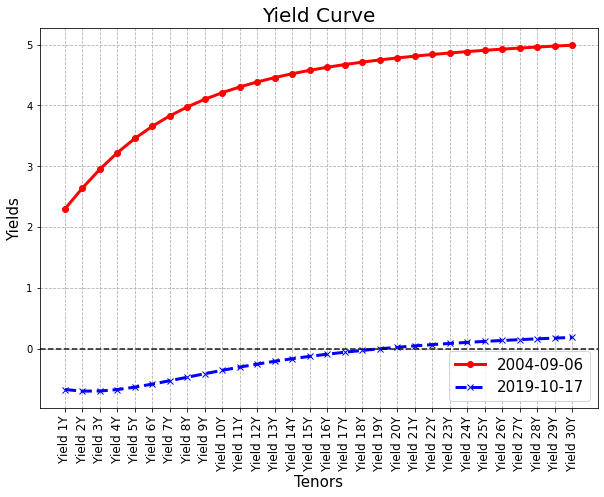

In [8]:
# 以下也是为了帮大家理解本题任务，不用操作
# 画出第一天和第二天的债券收益率曲线
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(yields_df.iloc[0],linestyle='-',marker='o',color='r',lw=3, label='2004-09-06')
ax.plot(yields_df.iloc[-1],linestyle='--',marker='x',color='b',lw=3, label='2019-10-17')
ax.axhline(y=0,ls='--',c='k',alpha=0.9)
ax.grid(linestyle='--')
ax.legend(loc = 'lower right', frameon=True, fontsize=15)
ax.xaxis.set_tick_params(rotation=90,labelsize=12)
ax.set_xlabel('Tenors', fontsize=15)
ax.set_ylabel('Yields', fontsize=15)
ax.set_title('Yield Curve', fontsize=20)
yields = yields_df.to_numpy() # 可以选择用numpy，也建议用numpy

### 2.1.1 用PCA提取主成分：（记得数据标准化，可以考虑用sklearn.preprocessing模块）

In [9]:
# todo
from sklearn.preprocessing import StandardScaler

X_std = StandardScaler().fit_transform(yields)
mean_vec = np.mean(X_std, axis = 0)
cov_mat = np.cov(X_std.T)
print(cov_mat.shape)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]
eig_pairs.sort(key = lambda x:x[0], reverse = True)
print(eig_pairs[0][0])
print(eig_pairs[0][1].shape)

(30, 30)
29.152617935500196
(30,)


### 2.1.2 绘制对原数据变换后的前3个主成分随时间的变化图：

(3, 3868)
(3, 30)


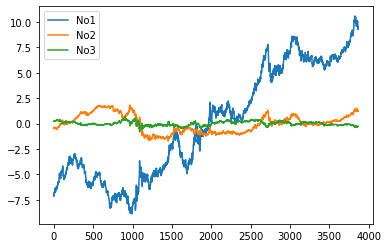

In [10]:
# todo
P = np.vstack((eig_pairs[0][1],eig_pairs[1][1],eig_pairs[2][1]))
res = np.dot(P,X_std.T)
print(res.shape)
print(P.shape)
x = range(res.shape[1])
plt.plot(x,res[0])
plt.plot(x,res[1])
plt.plot(x,res[2])
plt.legend(["No1","No2", "No3"])

### 2.1.3 计算每个主成分解释的方差，并以合理的可视化。（如：柱状图，折线图，表格，可以参考PPT等）

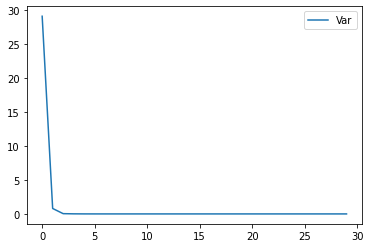

In [11]:
# todo
var = np.empty(len(eig_pairs))
for i in range(len(eig_pairs)):
    var[i] = np.var(np.dot(eig_pairs[i][1],X_std.T).reshape(-1))
a0 = range(len(eig_pairs))
plt.plot(a0,var)
plt.legend(["Var"])

### 2.1.4 绘制前三个特征向量(横轴为30个期限，纵轴为对应期限在前三个特征方向上的载荷）：
给出了一个示例输出，因为每个人的操作不同所以很可能**很不一样**

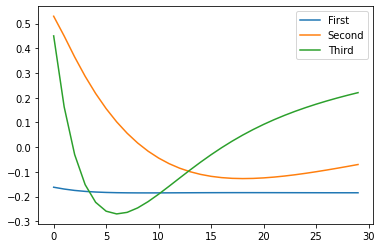

In [12]:
# todo
x = range(eig_pairs[0][1].shape[0])
plt.plot(x,eig_pairs[0][1])
plt.plot(x,eig_pairs[1][1])
plt.plot(x,eig_pairs[2][1])
plt.legend(["First","Second", "Third"])

### 2.1.5（附加题，1分） 分别用第1个，前2个，前3个因子重建最近一天（2019年10月17日）的yield curve.

对比三张图：你能给每个PC取个名字吗？（不算分）:1. 极大差异轴，2. 波动轴

In [13]:
def PCA(dim):
    means = np.mean(yields, axis=0)
    std = np.std(yields, axis=0)
    x = yields - means
    x = x/std
    c = np.cov(x.T, bias=True)
    l_vals, l_vec = np.linalg.eig(c)
    vals_id = np.argsort(-l_vals)
    p = l_vec[:, vals_id]
    p = p[:, 0:dim]
    res = x @ p
    return res, p

def PCA_reconstruct(dim):
    # todo
    mean = np.mean(yields, axis=0)
    std = np.std(yields, axis=0)
    res, p = PCA(dim)
    recon = res @ p.T 
    recon_y = recon[-1] * std + mean
    fig, ax = plt.subplots(figsize=(5,5))
    ax.plot(recon_y, label='Rec')
    ax.plot(yields_df.iloc[-1], label='Ori')
    ax.grid(linestyle='--')
    ax.set_title(f'Top {dim} dims', fontsize=20)
    ax.legend(loc = 'lower right', frameon=True, fontsize=15)
    ax.xaxis.set_tick_params(rotation=90,labelsize=12)



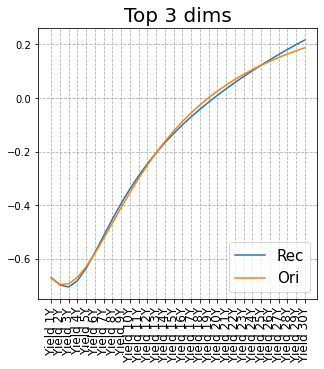

In [14]:
PCA_reconstruct(3)

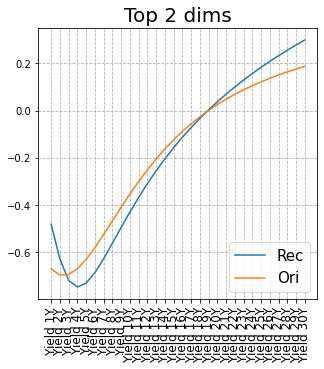

In [15]:
PCA_reconstruct(2)

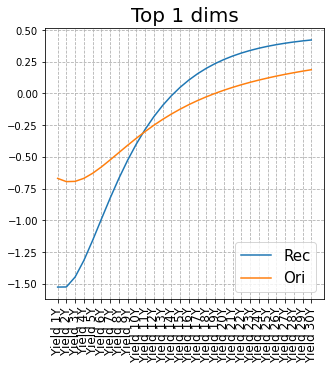

In [16]:
PCA_reconstruct(1)

### 2.2 numpy综合与聚类：图片处理与颜色压缩（3分）

计算机图形学中，颜色可以被量化为颜色空间。彩色图像一般有红绿蓝三个通道，每个通道取值通常为0~255。如果两个像素点只是在单个通道只有细微差异（例如R197G255B25和R198G255B25），在存储上也是不同的，但从观感来讲这两种色彩对我们来说基本没有区别。色彩量化就是找到一些具有代表性的颜色（16,32,64种）来表示全图像，量化前每个像素需要3bytes存储，量化后只需要存储其色彩标号，为1个byte。因此使得需要的存储空间大大减小。

首先我们有一张猫猫图，来自于北大猫协的公众号。


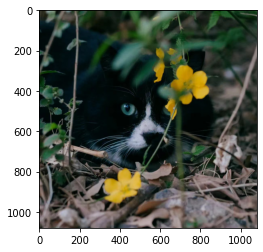

In [17]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

plt.figure()
img = plt.imread('./cat.jpeg')
plt.imshow(img)

把颜色分布画在3维坐标图上，颜色使用点对应的颜色。（本来想出成题的，但是这次就算了）

/home/gyr/anaconda3/envs/rlgpu/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  after removing the cwd from sys.path.


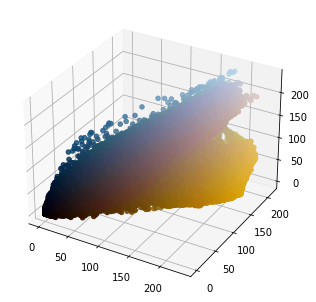

In [18]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)
shape = img.shape
I = img.reshape(shape[0]*shape[1], shape[2])
ax.scatter(I[:,0],I[:,1],I[:,2],c=I.reshape(-1, 3)/255)
plt.show(ax)

##### 想法一（naive approach）：计算特定颜色的使用次数，并使用最常见的颜色进行量化（量化到16色）


1. 加载图片
2. 找出独特颜色的数量及其频率
3. 找到出现频率最高的16个颜色（考察numpy操作）
4. 用最接近的颜色替换原始图像中的颜色（计算距离，可以使用scipy.spatial包）
5. 展示

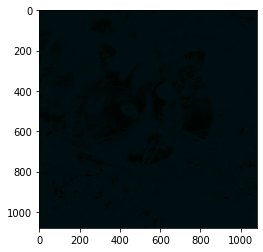

In [19]:
# todo
import scipy.spatial

# unique, counts = np.unique(img_array, return_counts=True)
# uc = list(zip(counts, unique))
# uc = sorted(uc,key = lambda x :x[0],reverse=True)
# # print(uc[:16])
# for i in range(16):
#     img_max16[i,0] = uc[i][1]%1000
#     img_max16[i,1] = (uc[i][1]%(1000*1000))/1000
#     img_max16[i,2] = uc[i][1]/(1000000)
# img_max16 = img_max16.astype(np.uint8)
# # print(img_max16)
# import scipy.spatial as spt
# tree = spt.cKDTree(data=img_max16)  
# distances, indexs = tree.query(img, k=2)
# indexs = indexs[:,:,0]
# img_new = img_max16[indexs]
colors, cnt = np.unique(I, axis=0, return_counts=True)
color_id = np.argsort(-cnt)
color_id = color_id[0:16]
top16 = colors[color_id, :]
new_img = np.zeros_like(img)
for i in range(shape[0]):
    for j in range(shape[1]):
        min_d = 10000000000000
        id = 0
        for k in range(16):
            d = scipy.spatial.distance.euclidean(img[i][j], top16[k])
            if d < min_d:
                min_d = d
                id = k
        new_img[i][j] = top16[id]
plt.imshow(new_img)

把量化后的16个颜色分布画在3维坐标图上，颜色使用点对应的颜色。（本来想出成题的，但是这次就算了）

/home/gyr/anaconda3/envs/rlgpu/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  """


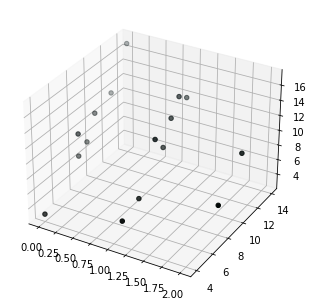

In [20]:
from mpl_toolkits.mplot3d import Axes3D
# C存储的是最频繁的颜色，你可以自己命名变量
C = top16
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(C[:,0],C[:,1],C[:,2],c=C.reshape(-1, 3)/255)
plt.show(ax)


##### 想法二（sophisticated approach）：K-Means

可以看到上面的方法颜色的失真十分严重，这是因为一些颜色比较微小的变化可能在原始图像中被过度表达，因此将出现在最常见的颜色中。从颜色空间中也可以看出来。我们需要另一种方法：也就是我们课上讲过的kmeans方法。寻找16个“颜色质心”，周围点用质心替代。可以调包，也可以自己实现。请在如下的block中实现。

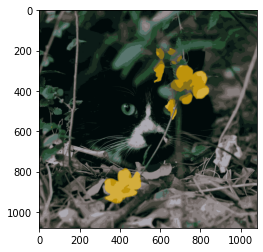

In [21]:
# todo
from sklearn.cluster import KMeans
k_res = KMeans(n_clusters=16).fit(I)
centroids = k_res.cluster_centers_
img_label = k_res.labels_

k_img = np.zeros_like(img)
img_label = img_label.reshape(shape[0], shape[1])

for i in range(shape[0]):
    for j in range(shape[1]):
        k_img[i][j] = centroids[img_label[i][j]]

plt.imshow(k_img)

/home/gyr/anaconda3/envs/rlgpu/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  """


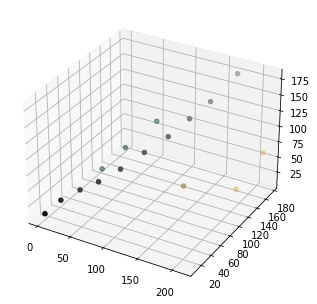

In [22]:
from mpl_toolkits.mplot3d import Axes3D
# 这里面的centroids是我存的颜色质心，你完全可以自己定义。

fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(centroids[:,0],centroids[:,1],centroids[:,2],c=centroids.reshape(-1, 3)/255)

### 附加题：PCA的另类用法（1分）

在著名的神经网络论文AlexNet中曾提出了一种使用PCA进行数据增强的算法，称之为PCA jitter。所谓数据增强，就是通过对训练数据人为的加噪声，提高模型鲁棒性与预测能力的方法。从观感来讲，PCA jitter近似对光效的变化，对比直接对RGB通道进行加噪声会获得更少的颜色的失真。请尝试按如下步骤对猫猫图基于PCA进行augmentation，生成4个结果并展示。


1. 将图片按照RGB三通道标准化，均值为0，方差为1。
2. 将图片按照channel展平成大小为(*, 3)的array
3. 对上述array求协方差矩阵
4. 对协方差矩阵进行特征分解
5. 对特征值进行“抖动”，抖动幅度自行设定，可以同样从正态分布中抽样
6. 还原图片（想想如何还原？需要进行一些数学推演）并展示

如果你能按照上面的步骤操作下来，一定会对PCA有更深刻的理解！
提示：
1. 要注意存储颜色的数据类型的转换，并对RGB的颜色用可能会踩一些坑，注意自己的数据是np.uint8，np.float32，np.int32还是什么？
2. RGB如果超出了0～255要用np.clip剪切处理一下
3. 参考[原论文](https://proceedings.neurips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf)

(1166400, 3)
(1166400, 3)
(3, 3)
[68 70 52]
(1080, 1080, 3)


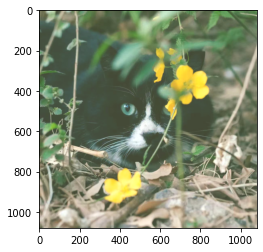

In [23]:
# todo
import random
import numpy as np
import matplotlib.pyplot as plt

img = plt.imread('./cat.jpeg')
shape = img.shape
# todo
l_img = img[:,:,:].astype(np.float64) 
l_img = l_img.reshape(-1, 3)
print(l_img.shape)

l_mean = np.mean(l_img, axis=0, keepdims=True)
l_std = np.std(l_img, axis=0, keepdims=True)

l_img -= l_mean
l_img /= l_std

print(l_img.shape)
c2 = np.cov(l_img.T, bias=True)
print(c2.shape)
l_val, l_vec = np.linalg.eig(c2)

rand = np.array([random.normalvariate(0, 0.2) for i in range(3)])

j_res = np.dot(l_val*rand, l_vec) * 255
j_res = j_res.astype(np.int32)
print(j_res)
res_img = img + j_res
res_img = np.clip(res_img, 0, 255)
print(res_img.shape)

plt.imshow(res_img)
